In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

print("🏠 BASELINE MODEL COMPARISON")
print("="*80)

# Load the final analysis dataset
df = pd.read_csv(r'C:\Users\Jc\Desktop\Dissertation\Code\finalized_baseline_dataset_categorical.csv')

print(f"Dataset loaded: {df.shape}")
print(f"Columns available: {len(df.columns)}")

# Check data quality
print(f"\n📊 DATA QUALITY CHECK:")
print(f"Price range: £{df['price'].min():,.0f} - £{df['price'].max():,.0f}")
print(f"Missing values in price: {df['price'].isna().sum()}")

def get_optimal_features_by_model(df, model_type):
    """
    Return optimal feature set based on model type and ACTUAL available columns
    FIXED: Handle categorical vs dummy variables properly
    """
    
    # CORE CONTINUOUS FEATURES (based on your actual dataset)
    core_features = [
        'bedrooms', 'bathrooms', 'size_sqft', 'parking', 'garden', 
        'council_tax', 'min_station_distance', 'nearby_stations_count'
    ]
    
    # CRIME FEATURES (based on your actual columns)
    recommended_crime_features = [
        'annual_crime_vehicle_crime',
        'annual_crime_other_theft',
        'annual_crime_shoplifting',
        'annual_crime_burglary',
        'annual_total_crimes',
        'annual_crime_theft_from_the_person',
        'annual_crime_robbery',
        'annual_crime_bicycle_theft',
        'annual_crime_public_order'
    ]
    
    # Check what type of property/tenure columns are available
    has_categorical = 'property_type' in df.columns and 'tenure_type' in df.columns
    has_dummies = any(col.startswith('property_') for col in df.columns if col != 'property_type')
    
    print(f"   📋 Feature type detection:")
    print(f"      - Has categorical columns: {has_categorical}")
    print(f"      - Has dummy variables: {has_dummies}")
    
    if model_type in ['linear_regression', 'random_forest']:
        # These models need dummy variables
        if has_categorical and not has_dummies:
            print(f"   ⚠️ {model_type} needs dummy variables, but only categorical found")
            print(f"   🔧 Will create dummy variables on-the-fly")
            # We'll handle this in the training functions
            feature_set = core_features + ['property_type', 'tenure_type'] + recommended_crime_features
        else:
            # Use existing dummies
            property_dummies = [col for col in df.columns if col.startswith('property_') and col != 'property_type']
            tenure_dummies = [col for col in df.columns if col.startswith('tenure_') and col != 'tenure_type']
            feature_set = core_features + property_dummies + tenure_dummies + recommended_crime_features
            
    elif model_type in ['xgboost', 'gradient_boosting']:
        # Tree-based models can handle categorical directly
        if has_categorical:
            print(f"   ✅ {model_type} can use categorical columns directly")
            feature_set = core_features + ['property_type', 'tenure_type'] + recommended_crime_features
        else:
            # Fall back to dummies if available
            property_dummies = [col for col in df.columns if col.startswith('property_')]
            tenure_dummies = [col for col in df.columns if col.startswith('tenure_')]
            feature_set = core_features + property_dummies + tenure_dummies + recommended_crime_features
    
    # Filter to only available features in dataset
    available_features = [col for col in feature_set if col in df.columns]
    
    print(f"   📊 Available features: {len(available_features)}/{len(feature_set)}")
    if len(available_features) != len(feature_set):
        missing = [col for col in feature_set if col not in df.columns]
        print(f"   ❌ Missing features: {missing}")
    
    return available_features

# UPDATED TRAINING FUNCTIONS

# 1. LINEAR REGRESSION - NEEDS DUMMIES
def train_linear_regression_baseline(df):
    print("\n" + "="*60)
    print("1️⃣ LINEAR REGRESSION BASELINE")
    print("="*60)
    
    # Get optimal features
    features = get_optimal_features_by_model(df, 'linear_regression')
    
    X = df[features].copy()
    y = df['price'].copy()
    
    # CREATE DUMMIES IF NEEDED
    if 'property_type' in X.columns:
        print("   🔧 Creating property_type dummies for Linear Regression...")
        property_dummies = pd.get_dummies(X['property_type'], prefix='property', drop_first=True)
        X = pd.concat([X.drop('property_type', axis=1), property_dummies], axis=1)
    
    if 'tenure_type' in X.columns:
        print("   🔧 Creating tenure_type dummies for Linear Regression...")
        tenure_dummies = pd.get_dummies(X['tenure_type'], prefix='tenure', drop_first=True)
        X = pd.concat([X.drop('tenure_type', axis=1), tenure_dummies], axis=1)
    
    # Clean data
    y = pd.to_numeric(y, errors='coerce')
    
    # Handle numeric features
    for col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)
    
    # Remove missing targets
    mask = y.notna()
    X, y = X[mask], y[mask]
    
    print(f"   📊 Final features used: {len(X.columns)}")
    print(f"   📊 Training samples: {len(X):,}")
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train model
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # Evaluate
    y_pred = lr_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f"\n✅ LINEAR REGRESSION RESULTS:")
    print(f"   R² Score: {r2:.4f}")
    print(f"   MAE: £{mae:,.0f}")
    print(f"   RMSE: £{rmse:,.0f}")
    
    return lr_model, r2, mae, rmse

# 2. RANDOM FOREST - NEEDS DUMMIES
def train_random_forest_baseline(df):
    print("\n" + "="*60)
    print("2️⃣ RANDOM FOREST BASELINE")
    print("="*60)
    
    # Get optimal features
    features = get_optimal_features_by_model(df, 'random_forest')
    
    X = df[features].copy()
    y = df['price'].copy()
    
    # CREATE DUMMIES IF NEEDED
    if 'property_type' in X.columns:
        print("   🔧 Creating property_type dummies for Random Forest...")
        property_dummies = pd.get_dummies(X['property_type'], prefix='property', drop_first=True)
        X = pd.concat([X.drop('property_type', axis=1), property_dummies], axis=1)
    
    if 'tenure_type' in X.columns:
        print("   🔧 Creating tenure_type dummies for Random Forest...")
        tenure_dummies = pd.get_dummies(X['tenure_type'], prefix='tenure', drop_first=True)
        X = pd.concat([X.drop('tenure_type', axis=1), tenure_dummies], axis=1)
    
    # Clean data
    y = pd.to_numeric(y, errors='coerce')
    
    # Handle numeric features
    for col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)
    
    # Remove missing targets
    mask = y.notna()
    X, y = X[mask], y[mask]
    
    print(f"   📊 Final features used: {len(X.columns)}")
    print(f"   📊 Training samples: {len(X):,}")
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train model
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train, y_train)
    
    # Evaluate
    y_pred = rf_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f"\n✅ RANDOM FOREST RESULTS:")
    print(f"   R² Score: {r2:.4f}")
    print(f"   MAE: £{mae:,.0f}")
    print(f"   RMSE: £{rmse:,.0f}")
    
    return rf_model, r2, mae, rmse

# 3. GRADIENT BOOSTING - CAN USE CATEGORICAL
def train_gradient_boosting_baseline(df):
    print("\n" + "="*60)
    print("3️⃣ GRADIENT BOOSTING BASELINE")
    print("="*60)
    
    # Get optimal features
    features = get_optimal_features_by_model(df, 'gradient_boosting')
    
    X = df[features].copy()
    y = df['price'].copy()
    
    # Clean data
    y = pd.to_numeric(y, errors='coerce')
    
    # Handle categorical features (Label Encoding for sklearn GBM)
    categorical_cols = ['property_type', 'tenure_type']
    encoders = {}
    
    for col in categorical_cols:
        if col in X.columns:
            print(f"   🔧 Label encoding {col} for Gradient Boosting...")
            le = LabelEncoder()
            X[col] = X[col].fillna('Unknown').astype(str)
            X[col] = le.fit_transform(X[col])
            encoders[col] = le
            print(f"      - {col}: {len(le.classes_)} categories")
    
    # Handle numeric features
    numeric_cols = [col for col in X.columns if col not in categorical_cols]
    for col in numeric_cols:
        X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)
    
    # Remove missing targets
    mask = y.notna()
    X, y = X[mask], y[mask]
    
    print(f"   📊 Final features used: {len(X.columns)}")
    print(f"   📊 Training samples: {len(X):,}")
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train model
    gbm_model = GradientBoostingRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42
    )
    gbm_model.fit(X_train, y_train)
    
    # Evaluate
    y_pred = gbm_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f"\n✅ GRADIENT BOOSTING RESULTS:")
    print(f"   R² Score: {r2:.4f}")
    print(f"   MAE: £{mae:,.0f}")
    print(f"   RMSE: £{rmse:,.0f}")
    
    return gbm_model, r2, mae, rmse

# 4. XGBOOST - CAN USE CATEGORICAL DIRECTLY
def train_xgboost_baseline(df):
    print("\n" + "="*60)
    print("4️⃣ XGBOOST BASELINE")
    print("="*60)
    
    # Get optimal features
    features = get_optimal_features_by_model(df, 'xgboost')
    
    X = df[features].copy()
    y = df['price'].copy()
    
    # Clean data
    y = pd.to_numeric(y, errors='coerce')
    
    # Handle categorical features for XGBoost (keep as categorical!)
    categorical_cols = ['property_type', 'tenure_type']
    for col in categorical_cols:
        if col in X.columns:
            print(f"   ✅ Using {col} as categorical for XGBoost...")
            X[col] = X[col].fillna('Unknown').astype('category')
            print(f"      - {col}: {X[col].nunique()} categories")
    
    # Handle numeric features
    numeric_cols = [col for col in X.columns if col not in categorical_cols]
    for col in numeric_cols:
        X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)
    
    # Remove missing targets
    mask = y.notna()
    X, y = X[mask], y[mask]
    
    print(f"   📊 Final features used: {len(X.columns)}")
    print(f"   📊 Training samples: {len(X):,}")
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train model with categorical support
    xgb_model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        enable_categorical=True,  # KEY: Enable categorical support
        tree_method='hist',
        random_state=42
    )
    xgb_model.fit(X_train, y_train)
    
    # Evaluate
    y_pred = xgb_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f"\n✅ XGBOOST RESULTS:")
    print(f"   R² Score: {r2:.4f}")
    print(f"   MAE: £{mae:,.0f}")
    print(f"   RMSE: £{rmse:,.0f}")
    
    return xgb_model, r2, mae, rmse

# RUN ALL BASELINE MODELS
print("\n🚀 TRAINING ALL BASELINE MODELS...")

# Train all models
lr_model, lr_r2, lr_mae, lr_rmse = train_linear_regression_baseline(df)
rf_model, rf_r2, rf_mae, rf_rmse = train_random_forest_baseline(df)
gbm_model, gbm_r2, gbm_mae, gbm_rmse = train_gradient_boosting_baseline(df)
xgb_model, xgb_r2, xgb_mae, xgb_rmse = train_xgboost_baseline(df)

# COMPARISON SUMMARY
print("\n" + "="*80)
print("📊 BASELINE MODEL COMPARISON SUMMARY")
print("="*80)

results = [
    ("Linear Regression", lr_r2, lr_mae, lr_rmse),
    ("Random Forest", rf_r2, rf_mae, rf_rmse),
    ("Gradient Boosting", gbm_r2, gbm_mae, gbm_rmse),
    ("XGBoost", xgb_r2, xgb_mae, xgb_rmse)
]

# Sort by R² score (descending)
results.sort(key=lambda x: x[1], reverse=True)

print(f"{'Model':<20} {'R² Score':<10} {'MAE (£)':<15} {'RMSE (£)':<15}")
print("-" * 70)

for i, (model, r2, mae, rmse) in enumerate(results):
    rank = "🥇" if i == 0 else "🥈" if i == 1 else "🥉" if i == 2 else "  "
    print(f"{rank} {model:<18} {r2:<10.4f} £{mae:<14,.0f} £{rmse:<14,.0f}")

# Best model insights
best_model, best_r2, best_mae, best_rmse = results[0]
print(f"\n🏆 BEST BASELINE MODEL: {best_model}")
print(f"   ✅ R² Score: {best_r2:.4f} ({best_r2*100:.1f}% variance explained)")
print(f"   ✅ MAE: £{best_mae:,.0f} (average prediction error)")
print(f"   ✅ RMSE: £{best_rmse:,.0f} (root mean squared error)")

# Performance insights
print(f"\n💡 KEY INSIGHTS:")
print(f"   📈 R² Range: {min(r[1] for r in results):.4f} - {max(r[1] for r in results):.4f}")
print(f"   💰 MAE Range: £{min(r[2] for r in results):,.0f} - £{max(r[2] for r in results):,.0f}")
print(f"   🎯 Best model explains {best_r2*100:.1f}% of price variance")
print(f"   📊 All models ready for hyperparameter tuning!")

🏠 BASELINE MODEL COMPARISON
Dataset loaded: (41826, 20)
Columns available: 20

📊 DATA QUALITY CHECK:
Price range: £50,000 - £44,000,000
Missing values in price: 0

🚀 TRAINING ALL BASELINE MODELS...

1️⃣ LINEAR REGRESSION BASELINE
   📋 Feature type detection:
      - Has categorical columns: True
      - Has dummy variables: False
   ⚠️ linear_regression needs dummy variables, but only categorical found
   🔧 Will create dummy variables on-the-fly
   📊 Available features: 19/19
   🔧 Creating property_type dummies for Linear Regression...
   🔧 Creating tenure_type dummies for Linear Regression...
   📊 Final features used: 78
   📊 Training samples: 41,826

✅ LINEAR REGRESSION RESULTS:
   R² Score: 0.3979
   MAE: £503,214
   RMSE: £1,103,157

2️⃣ RANDOM FOREST BASELINE
   📋 Feature type detection:
      - Has categorical columns: True
      - Has dummy variables: False
   ⚠️ random_forest needs dummy variables, but only categorical found
   🔧 Will create dummy variables on-the-fly
   📊 Avai

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

print("🏠 BASELINE MODEL COMPARISON WITH TRAIN & TEST PERFORMANCE")
print("="*80)

# Load the final analysis dataset
df = pd.read_csv(r'C:\Users\Jc\Desktop\Dissertation\Code\finalized_baseline_dataset_categorical.csv')

print(f"Dataset loaded: {df.shape}")
print(f"Columns available: {len(df.columns)}")

# Check data quality
print(f"\n📊 DATA QUALITY CHECK:")
print(f"Price range: £{df['price'].min():,.0f} - £{df['price'].max():,.0f}")
print(f"Missing values in price: {df['price'].isna().sum()}")

def get_optimal_features_by_model(df, model_type):
    """
    Return optimal feature set based on model type and ACTUAL available columns
    """
    
    # CORE CONTINUOUS FEATURES (based on your actual dataset)
    core_features = [
        'bedrooms', 'bathrooms', 'size_sqft', 'parking', 'garden', 
        'council_tax', 'min_station_distance', 'nearby_stations_count'
    ]
    
    # CRIME FEATURES (based on your actual columns)
    recommended_crime_features = [
        'annual_crime_vehicle_crime',
        'annual_crime_other_theft',
        'annual_crime_shoplifting',
        'annual_crime_burglary',
        'annual_total_crimes',
        'annual_crime_theft_from_the_person',
        'annual_crime_robbery',
        'annual_crime_bicycle_theft',
        'annual_crime_public_order'
    ]
    
    # Check what type of property/tenure columns are available
    has_categorical = 'property_type' in df.columns and 'tenure_type' in df.columns
    has_dummies = any(col.startswith('property_') for col in df.columns if col != 'property_type')
    
    print(f"   📋 Feature type detection:")
    print(f"      - Has categorical columns: {has_categorical}")
    print(f"      - Has dummy variables: {has_dummies}")
    
    if model_type in ['linear_regression', 'random_forest']:
        # These models need dummy variables
        if has_categorical and not has_dummies:
            print(f"   ⚠️ {model_type} needs dummy variables, but only categorical found")
            print(f"   🔧 Will create dummy variables on-the-fly")
            feature_set = core_features + ['property_type', 'tenure_type'] + recommended_crime_features
        else:
            # Use existing dummies
            property_dummies = [col for col in df.columns if col.startswith('property_') and col != 'property_type']
            tenure_dummies = [col for col in df.columns if col.startswith('tenure_') and col != 'tenure_type']
            feature_set = core_features + property_dummies + tenure_dummies + recommended_crime_features
            
    elif model_type in ['xgboost', 'gradient_boosting']:
        # Tree-based models can handle categorical directly
        if has_categorical:
            print(f"   ✅ {model_type} can use categorical columns directly")
            feature_set = core_features + ['property_type', 'tenure_type'] + recommended_crime_features
        else:
            # Fall back to dummies if available
            property_dummies = [col for col in df.columns if col.startswith('property_')]
            tenure_dummies = [col for col in df.columns if col.startswith('tenure_')]
            feature_set = core_features + property_dummies + tenure_dummies + recommended_crime_features
    
    # Filter to only available features in dataset
    available_features = [col for col in feature_set if col in df.columns]
    
    print(f"   📊 Available features: {len(available_features)}/{len(feature_set)}")
    if len(available_features) != len(feature_set):
        missing = [col for col in feature_set if col not in df.columns]
        print(f"   ❌ Missing features: {missing}")
    
    return available_features

def evaluate_model_complete(model, X_train, y_train, X_test, y_test, model_name):
    """Complete evaluation showing both training and test performance"""
    
    # Training performance
    y_train_pred = model.predict(X_train)
    train_r2 = r2_score(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
    
    # Test performance
    y_test_pred = model.predict(X_test)
    test_r2 = r2_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
    
    print(f"\n✅ {model_name.upper()} RESULTS:")
    print(f"   📈 TRAINING PERFORMANCE:")
    print(f"      R² Score: {train_r2:.4f} ({train_r2*100:.1f}% variance explained)")
    print(f"      MAE: £{train_mae:,.0f}")
    print(f"      RMSE: £{train_rmse:,.0f}")
    print(f"      MAPE: {train_mape:.2f}%")
    
    print(f"   📉 TEST PERFORMANCE:")
    print(f"      R² Score: {test_r2:.4f} ({test_r2*100:.1f}% variance explained)")
    print(f"      MAE: £{test_mae:,.0f}")
    print(f"      RMSE: £{test_rmse:,.0f}")
    print(f"      MAPE: {test_mape:.2f}%")
    
    # Overfitting analysis
    r2_diff = train_r2 - test_r2
    mae_diff = test_mae - train_mae
    
    print(f"   🔍 OVERFITTING ANALYSIS:")
    print(f"      R² Gap: {r2_diff:.4f} ({'⚠️ High' if r2_diff > 0.05 else '✅ Low'} overfitting)")
    print(f"      MAE Increase: £{mae_diff:,.0f}")
    
    return {
        'train': (train_r2, train_mae, train_rmse, train_mape),
        'test': (test_r2, test_mae, test_rmse, test_mape)
    }

# 1. LINEAR REGRESSION - NEEDS DUMMIES
def train_linear_regression_baseline(df):
    print("\n" + "="*60)
    print("1️⃣ LINEAR REGRESSION BASELINE")
    print("="*60)
    
    # Get optimal features
    features = get_optimal_features_by_model(df, 'linear_regression')
    
    X = df[features].copy()
    y = df['price'].copy()
    
    # CREATE DUMMIES IF NEEDED
    if 'property_type' in X.columns:
        print("   🔧 Creating property_type dummies for Linear Regression...")
        property_dummies = pd.get_dummies(X['property_type'], prefix='property', drop_first=True)
        X = pd.concat([X.drop('property_type', axis=1), property_dummies], axis=1)
    
    if 'tenure_type' in X.columns:
        print("   🔧 Creating tenure_type dummies for Linear Regression...")
        tenure_dummies = pd.get_dummies(X['tenure_type'], prefix='tenure', drop_first=True)
        X = pd.concat([X.drop('tenure_type', axis=1), tenure_dummies], axis=1)
    
    # Clean data
    y = pd.to_numeric(y, errors='coerce')
    
    # Handle numeric features
    for col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)
    
    # Remove missing targets
    mask = y.notna()
    X, y = X[mask], y[mask]
    
    print(f"   📊 Final features used: {len(X.columns)}")
    print(f"   📊 Total samples: {len(X):,}")
    
    # 🔑 PROPER TRAIN-TEST SPLIT
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    print(f"   📈 Training samples: {len(X_train):,}")
    print(f"   📉 Testing samples: {len(X_test):,}")
    
    # Train model
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # Complete evaluation
    results = evaluate_model_complete(lr_model, X_train, y_train, X_test, y_test, "Linear Regression")
    
    return lr_model, results

# 2. RANDOM FOREST - NEEDS DUMMIES
# 2. RANDOM FOREST - TUNED FOR BETTER GENERALIZATION
def train_random_forest_baseline(df):
    print("\n" + "="*60)
    print("2️⃣ RANDOM FOREST BASELINE (TUNED)")
    print("="*60)
    
    # Get optimal features
    features = get_optimal_features_by_model(df, 'random_forest')
    
    X = df[features].copy()
    y = df['price'].copy()
    
    # CREATE DUMMIES IF NEEDED
    if 'property_type' in X.columns:
        print("   🔧 Creating property_type dummies for Random Forest...")
        property_dummies = pd.get_dummies(X['property_type'], prefix='property', drop_first=True)
        X = pd.concat([X.drop('property_type', axis=1), property_dummies], axis=1)
    
    if 'tenure_type' in X.columns:
        print("   🔧 Creating tenure_type dummies for Random Forest...")
        tenure_dummies = pd.get_dummies(X['tenure_type'], prefix='tenure', drop_first=True)
        X = pd.concat([X.drop('tenure_type', axis=1), tenure_dummies], axis=1)
    
    # Clean data
    y = pd.to_numeric(y, errors='coerce')
    
    # Handle numeric features
    for col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)
    
    # Remove missing targets
    mask = y.notna()
    X, y = X[mask], y[mask]
    
    print(f"   📊 Final features used: {len(X.columns)}")
    print(f"   📊 Total samples: {len(X):,}")
    
    # 🔑 PROPER TRAIN-TEST SPLIT
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    print(f"   📈 Training samples: {len(X_train):,}")
    print(f"   📉 Testing samples: {len(X_test):,}")
    
    # ✅ TUNED MODEL - REDUCED OVERFITTING
    rf_model = RandomForestRegressor(
        n_estimators=50,              # Reduced from 100
        max_depth=6,                  # Reduced from 10
        min_samples_split=10,         # Added regularization
        min_samples_leaf=5,           # Added regularization
        max_features='sqrt',          # Reduced feature sampling
        bootstrap=True,               # Enable bootstrap sampling
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train, y_train)
    
    print("   🎛️ Tuned hyperparameters for better generalization:")
    print("      - n_estimators: 50 (vs 100)")
    print("      - max_depth: 6 (vs 10)")
    print("      - min_samples_split: 10")
    print("      - min_samples_leaf: 5")
    print("      - max_features: 'sqrt'")
    
    # Complete evaluation
    results = evaluate_model_complete(rf_model, X_train, y_train, X_test, y_test, "Random Forest (Tuned)")
    
    return rf_model, results

# 3. GRADIENT BOOSTING - TUNED FOR BETTER GENERALIZATION
def train_gradient_boosting_baseline(df):
    print("\n" + "="*60)
    print("3️⃣ GRADIENT BOOSTING BASELINE (TUNED)")
    print("="*60)
    
    # Get optimal features
    features = get_optimal_features_by_model(df, 'gradient_boosting')
    
    X = df[features].copy()
    y = df['price'].copy()
    
    # Clean data
    y = pd.to_numeric(y, errors='coerce')
    
    # Handle categorical features (Label Encoding for sklearn GBM)
    categorical_cols = ['property_type', 'tenure_type']
    encoders = {}
    
    for col in categorical_cols:
        if col in X.columns:
            print(f"   🔧 Label encoding {col} for Gradient Boosting...")
            le = LabelEncoder()
            X[col] = X[col].fillna('Unknown').astype(str)
            X[col] = le.fit_transform(X[col])
            encoders[col] = le
            print(f"      - {col}: {len(le.classes_)} categories")
    
    # Handle numeric features
    numeric_cols = [col for col in X.columns if col not in categorical_cols]
    for col in numeric_cols:
        X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)
    
    # Remove missing targets
    mask = y.notna()
    X, y = X[mask], y[mask]
    
    print(f"   📊 Final features used: {len(X.columns)}")
    print(f"   📊 Total samples: {len(X):,}")
    
    # 🔑 PROPER TRAIN-TEST SPLIT
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    print(f"   📈 Training samples: {len(X_train):,}")
    print(f"   📉 Testing samples: {len(X_test):,}")
    
    # ✅ TUNED MODEL - REDUCED OVERFITTING
    gbm_model = GradientBoostingRegressor(
        n_estimators=50,              # Reduced from 100
        max_depth=4,                  # Reduced from 6
        learning_rate=0.05,           # Reduced from 0.1
        min_samples_split=20,         # Added regularization
        min_samples_leaf=10,          # Added regularization
        max_features='sqrt',          # Reduced feature sampling
        subsample=0.8,                # Added row sampling
        random_state=42
    )
    gbm_model.fit(X_train, y_train)
    
    print("   🎛️ Tuned hyperparameters for better generalization:")
    print("      - n_estimators: 50 (vs 100)")
    print("      - max_depth: 4 (vs 6)")
    print("      - learning_rate: 0.05 (vs 0.1)")
    print("      - min_samples_split: 20")
    print("      - min_samples_leaf: 10")
    print("      - subsample: 0.8")
    
    # Complete evaluation
    results = evaluate_model_complete(gbm_model, X_train, y_train, X_test, y_test, "Gradient Boosting (Tuned)")
    
    return gbm_model, results

# 4. XGBOOST - TUNED FOR BETTER GENERALIZATION
def train_xgboost_baseline(df):
    print("\n" + "="*60)
    print("4️⃣ XGBOOST BASELINE (TUNED)")
    print("="*60)
    
    # Get optimal features
    features = get_optimal_features_by_model(df, 'xgboost')
    
    X = df[features].copy()
    y = df['price'].copy()
    
    # Clean data
    y = pd.to_numeric(y, errors='coerce')
    
    # Handle categorical features for XGBoost (keep as categorical!)
    categorical_cols = ['property_type', 'tenure_type']
    for col in categorical_cols:
        if col in X.columns:
            print(f"   ✅ Using {col} as categorical for XGBoost...")
            X[col] = X[col].fillna('Unknown').astype('category')
            print(f"      - {col}: {X[col].nunique()} categories")
    
    # Handle numeric features
    numeric_cols = [col for col in X.columns if col not in categorical_cols]
    for col in numeric_cols:
        X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)
    
    # Remove missing targets
    mask = y.notna()
    X, y = X[mask], y[mask]
    
    print(f"   📊 Final features used: {len(X.columns)}")
    print(f"   📊 Total samples: {len(X):,}")
    
    # 🔑 PROPER TRAIN-TEST SPLIT
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    print(f"   📈 Training samples: {len(X_train):,}")
    print(f"   📉 Testing samples: {len(X_test):,}")
    
    # ✅ TUNED MODEL - REDUCED OVERFITTING
    xgb_model = xgb.XGBRegressor(
        n_estimators=50,              # Reduced from 100
        max_depth=4,                  # Reduced from 6
        learning_rate=0.05,           # Reduced from 0.1
        min_child_weight=5,           # Added regularization
        gamma=0.1,                    # Added regularization
        subsample=0.8,                # Added row sampling
        colsample_bytree=0.8,         # Added column sampling
        reg_alpha=0.1,                # L1 regularization
        reg_lambda=1.0,               # L2 regularization
        enable_categorical=True,      # Enable categorical support
        tree_method='hist',
        random_state=42
    )
    xgb_model.fit(X_train, y_train)
    
    print("   🎛️ Tuned hyperparameters for better generalization:")
    print("      - n_estimators: 50 (vs 100)")
    print("      - max_depth: 4 (vs 6)")
    print("      - learning_rate: 0.05 (vs 0.1)")
    print("      - min_child_weight: 5")
    print("      - gamma: 0.1")
    print("      - subsample: 0.8")
    print("      - colsample_bytree: 0.8")
    print("      - reg_alpha: 0.1, reg_lambda: 1.0")
    
    # Complete evaluation
    results = evaluate_model_complete(xgb_model, X_train, y_train, X_test, y_test, "XGBoost (Tuned)")
    
    return xgb_model, results

# 🚀 RUN ALL BASELINE MODELS WITH PROPER TRAIN-TEST SPLITS
print("\n🚀 TRAINING ALL BASELINE MODELS WITH TRAIN & TEST EVALUATION...")
print("🔑 Using 80-20 train-test split (random_state=42 for reproducibility)")

# Train all models
lr_model, lr_results = train_linear_regression_baseline(df)
rf_model, rf_results = train_random_forest_baseline(df)
gbm_model, gbm_results = train_gradient_boosting_baseline(df)
xgb_model, xgb_results = train_xgboost_baseline(df)

# COMPREHENSIVE COMPARISON SUMMARY
print("\n" + "="*120)
print("📊 COMPREHENSIVE BASELINE MODEL COMPARISON")
print("="*120)

# Create results for both train and test
train_results = [
    ("Linear Regression", lr_results['train'][0], lr_results['train'][1], lr_results['train'][2], lr_results['train'][3]),
    ("Random Forest", rf_results['train'][0], rf_results['train'][1], rf_results['train'][2], rf_results['train'][3]),
    ("Gradient Boosting", gbm_results['train'][0], gbm_results['train'][1], gbm_results['train'][2], gbm_results['train'][3]),
    ("XGBoost", xgb_results['train'][0], xgb_results['train'][1], xgb_results['train'][2], xgb_results['train'][3])
]

test_results = [
    ("Linear Regression", lr_results['test'][0], lr_results['test'][1], lr_results['test'][2], lr_results['test'][3]),
    ("Random Forest", rf_results['test'][0], rf_results['test'][1], rf_results['test'][2], rf_results['test'][3]),
    ("Gradient Boosting", gbm_results['test'][0], gbm_results['test'][1], gbm_results['test'][2], gbm_results['test'][3]),
    ("XGBoost", xgb_results['test'][0], xgb_results['test'][1], xgb_results['test'][2], xgb_results['test'][3])
]

# Sort by test R² score (descending) - this is what matters most
test_results.sort(key=lambda x: x[1], reverse=True)
train_results.sort(key=lambda x: x[1], reverse=True)

print("🎯 TRAINING SET PERFORMANCE:")
print(f"{'Model':<20} {'R² Score':<10} {'MAE (£)':<15} {'RMSE (£)':<15} {'MAPE (%)':<10}")
print("-" * 80)

for i, (model, r2, mae, rmse, mape) in enumerate(train_results):
    rank = "🥇" if i == 0 else "🥈" if i == 1 else "🥉" if i == 2 else "  "
    print(f"{rank} {model:<18} {r2:<10.4f} £{mae:<14,.0f} £{rmse:<14,.0f} {mape:<9.2f}%")

print("\n🎯 TEST SET PERFORMANCE (UNBIASED):")
print(f"{'Model':<20} {'R² Score':<10} {'MAE (£)':<15} {'RMSE (£)':<15} {'MAPE (%)':<10}")
print("-" * 80)

for i, (model, r2, mae, rmse, mape) in enumerate(test_results):
    rank = "🥇" if i == 0 else "🥈" if i == 1 else "🥉" if i == 2 else "  "
    print(f"{rank} {model:<18} {r2:<10.4f} £{mae:<14,.0f} £{rmse:<14,.0f} {mape:<9.2f}%")

# Best model insights (based on TEST performance)
best_model, best_r2, best_mae, best_rmse, best_mape = test_results[0]
print(f"\n🏆 BEST BASELINE MODEL (TEST PERFORMANCE): {best_model}")
print(f"   ✅ Test R² Score: {best_r2:.4f} ({best_r2*100:.1f}% variance explained)")
print(f"   ✅ Test MAE: £{best_mae:,.0f} (average prediction error)")
print(f"   ✅ Test RMSE: £{best_rmse:,.0f} (root mean squared error)")
print(f"   ✅ Test MAPE: {best_mape:.2f}% (mean absolute percentage error)")

# Overfitting Analysis Summary
print(f"\n🔍 OVERFITTING ANALYSIS:")
models_data = [
    ("Linear Regression", lr_results),
    ("Random Forest", rf_results),
    ("Gradient Boosting", gbm_results),
    ("XGBoost", xgb_results)
]

for model_name, results in models_data:
    train_r2, train_mae = results['train'][0], results['train'][1]
    test_r2, test_mae = results['test'][0], results['test'][1]
    r2_gap = train_r2 - test_r2
    mae_increase = test_mae - train_mae
    
    overfitting_status = "⚠️ High" if r2_gap > 0.05 else "✅ Low"
    print(f"   {model_name:<18}: R² Gap = {r2_gap:.4f} ({overfitting_status}), MAE Increase = £{mae_increase:,.0f}")

# Performance insights
print(f"\n💡 KEY INSIGHTS:")
print(f"   📈 Test R² Range: {min(r[1] for r in test_results):.4f} - {max(r[1] for r in test_results):.4f}")
print(f"   💰 Test MAE Range: £{min(r[2] for r in test_results):,.0f} - £{max(r[2] for r in test_results):,.0f}")
print(f"   🎯 Best model explains {best_r2*100:.1f}% of price variance on unseen data")
print(f"   🔄 All models evaluated on UNSEEN test data (20% hold-out)")
print(f"   📊 Results are unbiased and ready for comparison with BERT models!")

print(f"\n🎯 BASELINE ESTABLISHED:")
print(f"   🏆 Target to beat: Test R² = {best_r2:.4f}, Test MAE = £{best_mae:,.0f}")
print(f"   🧠 BERT models should exceed these metrics to demonstrate value-add")
print(f"   📈 Training performance shows model capacity, test performance shows generalization")

🏠 BASELINE MODEL COMPARISON WITH TRAIN & TEST PERFORMANCE
Dataset loaded: (41826, 21)
Columns available: 21

📊 DATA QUALITY CHECK:
Price range: £50,000 - £44,000,000
Missing values in price: 0

🚀 TRAINING ALL BASELINE MODELS WITH TRAIN & TEST EVALUATION...
🔑 Using 80-20 train-test split (random_state=42 for reproducibility)

1️⃣ LINEAR REGRESSION BASELINE
   📋 Feature type detection:
      - Has categorical columns: True
      - Has dummy variables: False
   ⚠️ linear_regression needs dummy variables, but only categorical found
   🔧 Will create dummy variables on-the-fly
   📊 Available features: 19/19
   🔧 Creating property_type dummies for Linear Regression...
   🔧 Creating tenure_type dummies for Linear Regression...
   📊 Final features used: 78
   📊 Total samples: 41,826
   📈 Training samples: 33,460
   📉 Testing samples: 8,366

✅ LINEAR REGRESSION RESULTS:
   📈 TRAINING PERFORMANCE:
      R² Score: 0.3350 (33.5% variance explained)
      MAE: £518,809
      RMSE: £1,241,592
      M

In [4]:
def get_rightmove_only_features(df):
    """
    Return ONLY features available in original Rightmove listings
    This creates fair comparison with BERT models
    """
    
    # CORE RIGHTMOVE FEATURES ONLY
    rightmove_features = [
        'bedrooms', 
        'bathrooms', 
        'size_sqft',     # If available in Rightmove
        'parking',       # Binary feature from text
        'garden',        # Binary feature from text
        'property_type', 
        'tenure_type'
    ]
    
    # Filter to only available features in dataset
    available_features = [col for col in rightmove_features if col in df.columns]
    
    print(f"   📋 RIGHTMOVE-ONLY FEATURES:")
    print(f"      Available: {len(available_features)}/{len(rightmove_features)}")
    for feature in available_features:
        print(f"      ✅ {feature}")
    
    if len(available_features) != len(rightmove_features):
        missing = [col for col in rightmove_features if col not in df.columns]
        print(f"      ❌ Missing: {missing}")
    
    return available_features

# RIGHTMOVE-ONLY BASELINE FUNCTIONS

def train_rightmove_linear_regression(df):
    print("\n" + "="*60)
    print("🏠 LINEAR REGRESSION - RIGHTMOVE FEATURES ONLY")
    print("="*60)
    
    # Get Rightmove-only features
    features = get_rightmove_only_features(df)
    
    X = df[features].copy()
    y = df['price'].copy()
    
    # CREATE DUMMIES FOR CATEGORICAL
    if 'property_type' in X.columns:
        print("   🔧 Creating property_type dummies...")
        property_dummies = pd.get_dummies(X['property_type'], prefix='property', drop_first=True)
        X = pd.concat([X.drop('property_type', axis=1), property_dummies], axis=1)
    
    if 'tenure_type' in X.columns:
        print("   🔧 Creating tenure_type dummies...")
        tenure_dummies = pd.get_dummies(X['tenure_type'], prefix='tenure', drop_first=True)
        X = pd.concat([X.drop('tenure_type', axis=1), tenure_dummies], axis=1)
    
    # Clean data
    y = pd.to_numeric(y, errors='coerce')
    for col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)
    
    # Remove missing targets
    mask = y.notna()
    X, y = X[mask], y[mask]
    
    print(f"   📊 Final features: {len(X.columns)} (Rightmove-only)")
    print(f"   📊 Samples: {len(X):,}")
    
    # Train-test split (same random_state for consistency)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train model
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # Evaluate
    results = evaluate_model_complete(lr_model, X_train, y_train, X_test, y_test, "Linear Regression (Rightmove-Only)")
    
    return lr_model, results

def train_rightmove_random_forest(df):
    print("\n" + "="*60)
    print("🏠 RANDOM FOREST - RIGHTMOVE FEATURES ONLY")
    print("="*60)
    
    # Get Rightmove-only features
    features = get_rightmove_only_features(df)
    
    X = df[features].copy()
    y = df['price'].copy()
    
    # CREATE DUMMIES FOR CATEGORICAL
    if 'property_type' in X.columns:
        print("   🔧 Creating property_type dummies...")
        property_dummies = pd.get_dummies(X['property_type'], prefix='property', drop_first=True)
        X = pd.concat([X.drop('property_type', axis=1), property_dummies], axis=1)
    
    if 'tenure_type' in X.columns:
        print("   🔧 Creating tenure_type dummies...")
        tenure_dummies = pd.get_dummies(X['tenure_type'], prefix='tenure', drop_first=True)
        X = pd.concat([X.drop('tenure_type', axis=1), tenure_dummies], axis=1)
    
    # Clean data
    y = pd.to_numeric(y, errors='coerce')
    for col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)
    
    # Remove missing targets
    mask = y.notna()
    X, y = X[mask], y[mask]
    
    print(f"   📊 Final features: {len(X.columns)} (Rightmove-only)")
    print(f"   📊 Samples: {len(X):,}")
    
    # Train-test split (same random_state for consistency)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Tuned Random Forest (same params as before)
    rf_model = RandomForestRegressor(
        n_estimators=50,
        max_depth=6,
        min_samples_split=10,
        min_samples_leaf=5,
        max_features='sqrt',
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train, y_train)
    
    # Evaluate
    results = evaluate_model_complete(rf_model, X_train, y_train, X_test, y_test, "Random Forest (Rightmove-Only)")
    
    return rf_model, results

def train_rightmove_xgboost(df):
    print("\n" + "="*60)
    print("🏠 XGBOOST - RIGHTMOVE FEATURES ONLY")
    print("="*60)
    
    # Get Rightmove-only features
    features = get_rightmove_only_features(df)
    
    X = df[features].copy()
    y = df['price'].copy()
    
    # Clean data
    y = pd.to_numeric(y, errors='coerce')
    
    # Handle categorical features for XGBoost
    categorical_cols = ['property_type', 'tenure_type']
    for col in categorical_cols:
        if col in X.columns:
            print(f"   ✅ Using {col} as categorical...")
            X[col] = X[col].fillna('Unknown').astype('category')
    
    # Handle numeric features
    numeric_cols = [col for col in X.columns if col not in categorical_cols]
    for col in numeric_cols:
        X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)
    
    # Remove missing targets
    mask = y.notna()
    X, y = X[mask], y[mask]
    
    print(f"   📊 Final features: {len(X.columns)} (Rightmove-only)")
    print(f"   📊 Samples: {len(X):,}")
    
    # Train-test split (same random_state for consistency)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Tuned XGBoost (same params as before)
    xgb_model = xgb.XGBRegressor(
        n_estimators=50,
        max_depth=4,
        learning_rate=0.05,
        min_child_weight=5,
        gamma=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=1.0,
        enable_categorical=True,
        tree_method='hist',
        random_state=42
    )
    xgb_model.fit(X_train, y_train)
    
    # Evaluate
    results = evaluate_model_complete(xgb_model, X_train, y_train, X_test, y_test, "XGBoost (Rightmove-Only)")
    
    return xgb_model, results

# RUN RIGHTMOVE-ONLY BASELINES
print("\n" + "🏠" * 60)
print("RIGHTMOVE-ONLY BASELINE MODELS (FAIR BERT COMPARISON)")
print("🏠" * 60)

print("\n🎯 PURPOSE: Create baselines using ONLY features available in Rightmove listings")
print("🔍 This ensures fair comparison with BERT models (same input data)")
print("📊 BERT can only use: property details + textual descriptions")

# Train Rightmove-only models
rm_lr_model, rm_lr_results = train_rightmove_linear_regression(df)
rm_rf_model, rm_rf_results = train_rightmove_random_forest(df)
rm_xgb_model, rm_xgb_results = train_rightmove_xgboost(df)

# Compare Rightmove-only results
print("\n" + "="*100)
print("📊 RIGHTMOVE-ONLY BASELINE COMPARISON")
print("="*100)

rm_test_results = [
    ("Linear Regression (RM)", rm_lr_results['test'][0], rm_lr_results['test'][1], rm_lr_results['test'][2], rm_lr_results['test'][3]),
    ("Random Forest (RM)", rm_rf_results['test'][0], rm_rf_results['test'][1], rm_rf_results['test'][2], rm_rf_results['test'][3]),
    ("XGBoost (RM)", rm_xgb_results['test'][0], rm_xgb_results['test'][1], rm_xgb_results['test'][2], rm_xgb_results['test'][3])
]

rm_test_results.sort(key=lambda x: x[1], reverse=True)

print("🎯 RIGHTMOVE-ONLY TEST PERFORMANCE:")
print(f"{'Model':<25} {'R² Score':<10} {'MAE (£)':<15} {'RMSE (£)':<15} {'MAPE (%)':<10}")
print("-" * 85)

for i, (model, r2, mae, rmse, mape) in enumerate(rm_test_results):
    rank = "🥇" if i == 0 else "🥈" if i == 1 else "🥉" if i == 2 else "  "
    print(f"{rank} {model:<23} {r2:<10.4f} £{mae:<14,.0f} £{rmse:<14,.0f} {mape:<9.2f}%")

# Best Rightmove-only model
best_rm_model, best_rm_r2, best_rm_mae, best_rm_rmse, best_rm_mape = rm_test_results[0]
print(f"\n🏆 BEST RIGHTMOVE-ONLY MODEL: {best_rm_model}")
print(f"   ✅ R² Score: {best_rm_r2:.4f} ({best_rm_r2*100:.1f}% variance explained)")
print(f"   ✅ MAE: £{best_rm_mae:,.0f}")

print(f"\n🎯 BERT MODELS MUST BEAT:")
print(f"   📈 Target R²: {best_rm_r2:.4f}")
print(f"   💰 Target MAE: £{best_rm_mae:,.0f}")
print(f"   🧠 This is the FAIR baseline for BERT comparison!")

# COMPARISON: Full Features vs Rightmove-Only
print(f"\n📊 FEATURE IMPACT ANALYSIS:")
print(f"   🔧 Full Features XGBoost:      R² = {best_r2:.4f}, MAE = £{best_mae:,.0f}")
print(f"   🏠 Rightmove-Only XGBoost:     R² = {best_rm_r2:.4f}, MAE = £{best_rm_mae:,.0f}")
print(f"   📉 Performance Drop:           ΔR² = {(best_r2 - best_rm_r2):.4f}, ΔMAE = £{(best_rm_mae - best_mae):,.0f}")
print(f"   💡 External data adds {((best_r2 - best_rm_r2)/best_rm_r2*100):.1f}% relative R² improvement")


🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠
RIGHTMOVE-ONLY BASELINE MODELS (FAIR BERT COMPARISON)
🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠

🎯 PURPOSE: Create baselines using ONLY features available in Rightmove listings
🔍 This ensures fair comparison with BERT models (same input data)
📊 BERT can only use: property details + textual descriptions

🏠 LINEAR REGRESSION - RIGHTMOVE FEATURES ONLY
   📋 RIGHTMOVE-ONLY FEATURES:
      Available: 7/7
      ✅ bedrooms
      ✅ bathrooms
      ✅ size_sqft
      ✅ parking
      ✅ garden
      ✅ property_type
      ✅ tenure_type
   🔧 Creating property_type dummies...
   🔧 Creating tenure_type dummies...
   📊 Final features: 66 (Rightmove-only)
   📊 Samples: 41,826

✅ LINEAR REGRESSION (RIGHTMOVE-ONLY) RESULTS:
   📈 TRAINING PERFORMANCE:
      R² Score: 0.2325 (23.3% variance explained)
      MAE: £537,288
      RMSE: £1,333,815
      MAPE: 62.25%
   📉 TEST PERFORMANCE:
      R² Score: 0.2931 (29.3% variance expla

In [5]:
def train_rightmove_gradient_boosting(df):
    print("\n" + "="*60)
    print("🏠 GRADIENT BOOSTING - RIGHTMOVE FEATURES ONLY")
    print("="*60)
    
    # Get Rightmove-only features
    features = get_rightmove_only_features(df)
    
    X = df[features].copy()
    y = df['price'].copy()
    
    # Clean data
    y = pd.to_numeric(y, errors='coerce')
    
    # Handle categorical features (Label Encoding for sklearn GBM)
    categorical_cols = ['property_type', 'tenure_type']
    encoders = {}
    
    for col in categorical_cols:
        if col in X.columns:
            print(f"   🔧 Label encoding {col} for Gradient Boosting...")
            le = LabelEncoder()
            X[col] = X[col].fillna('Unknown').astype(str)
            X[col] = le.fit_transform(X[col])
            encoders[col] = le
            print(f"      - {col}: {len(le.classes_)} categories")
    
    # Handle numeric features
    numeric_cols = [col for col in X.columns if col not in categorical_cols]
    for col in numeric_cols:
        X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)
    
    # Remove missing targets
    mask = y.notna()
    X, y = X[mask], y[mask]
    
    print(f"   📊 Final features: {len(X.columns)} (Rightmove-only)")
    print(f"   📊 Samples: {len(X):,}")
    
    # Train-test split (same random_state for consistency)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Tuned Gradient Boosting (same params as before)
    gbm_model = GradientBoostingRegressor(
        n_estimators=50,              # Reduced from 100
        max_depth=4,                  # Reduced from 6
        learning_rate=0.05,           # Reduced from 0.1
        min_samples_split=20,         # Added regularization
        min_samples_leaf=10,          # Added regularization
        max_features='sqrt',          # Reduced feature sampling
        subsample=0.8,                # Added row sampling
        random_state=42
    )
    gbm_model.fit(X_train, y_train)
    
    # Evaluate
    results = evaluate_model_complete(gbm_model, X_train, y_train, X_test, y_test, "Gradient Boosting (Rightmove-Only)")
    
    return gbm_model, results

# UPDATE THE RIGHTMOVE-ONLY TRAINING SECTION:
# Train Rightmove-only models
rm_lr_model, rm_lr_results = train_rightmove_linear_regression(df)
rm_rf_model, rm_rf_results = train_rightmove_random_forest(df)
rm_gbm_model, rm_gbm_results = train_rightmove_gradient_boosting(df)  # ADD THIS LINE
rm_xgb_model, rm_xgb_results = train_rightmove_xgboost(df)

# UPDATE THE COMPARISON SECTION:
rm_test_results = [
    ("Linear Regression (RM)", rm_lr_results['test'][0], rm_lr_results['test'][1], rm_lr_results['test'][2], rm_lr_results['test'][3]),
    ("Random Forest (RM)", rm_rf_results['test'][0], rm_rf_results['test'][1], rm_rf_results['test'][2], rm_rf_results['test'][3]),
    ("Gradient Boosting (RM)", rm_gbm_results['test'][0], rm_gbm_results['test'][1], rm_gbm_results['test'][2], rm_gbm_results['test'][3]),  # ADD THIS LINE
    ("XGBoost (RM)", rm_xgb_results['test'][0], rm_xgb_results['test'][1], rm_xgb_results['test'][2], rm_xgb_results['test'][3])
]


🏠 LINEAR REGRESSION - RIGHTMOVE FEATURES ONLY
   📋 RIGHTMOVE-ONLY FEATURES:
      Available: 7/7
      ✅ bedrooms
      ✅ bathrooms
      ✅ size_sqft
      ✅ parking
      ✅ garden
      ✅ property_type
      ✅ tenure_type
   🔧 Creating property_type dummies...
   🔧 Creating tenure_type dummies...
   📊 Final features: 66 (Rightmove-only)
   📊 Samples: 41,826

✅ LINEAR REGRESSION (RIGHTMOVE-ONLY) RESULTS:
   📈 TRAINING PERFORMANCE:
      R² Score: 0.2325 (23.3% variance explained)
      MAE: £537,288
      RMSE: £1,333,815
      MAPE: 62.25%
   📉 TEST PERFORMANCE:
      R² Score: 0.2931 (29.3% variance explained)
      MAE: £531,906
      RMSE: £1,195,328
      MAPE: 62.88%
   🔍 OVERFITTING ANALYSIS:
      R² Gap: -0.0606 (✅ Low overfitting)
      MAE Increase: £-5,382

🏠 RANDOM FOREST - RIGHTMOVE FEATURES ONLY
   📋 RIGHTMOVE-ONLY FEATURES:
      Available: 7/7
      ✅ bedrooms
      ✅ bathrooms
      ✅ size_sqft
      ✅ parking
      ✅ garden
      ✅ property_type
      ✅ tenure_type


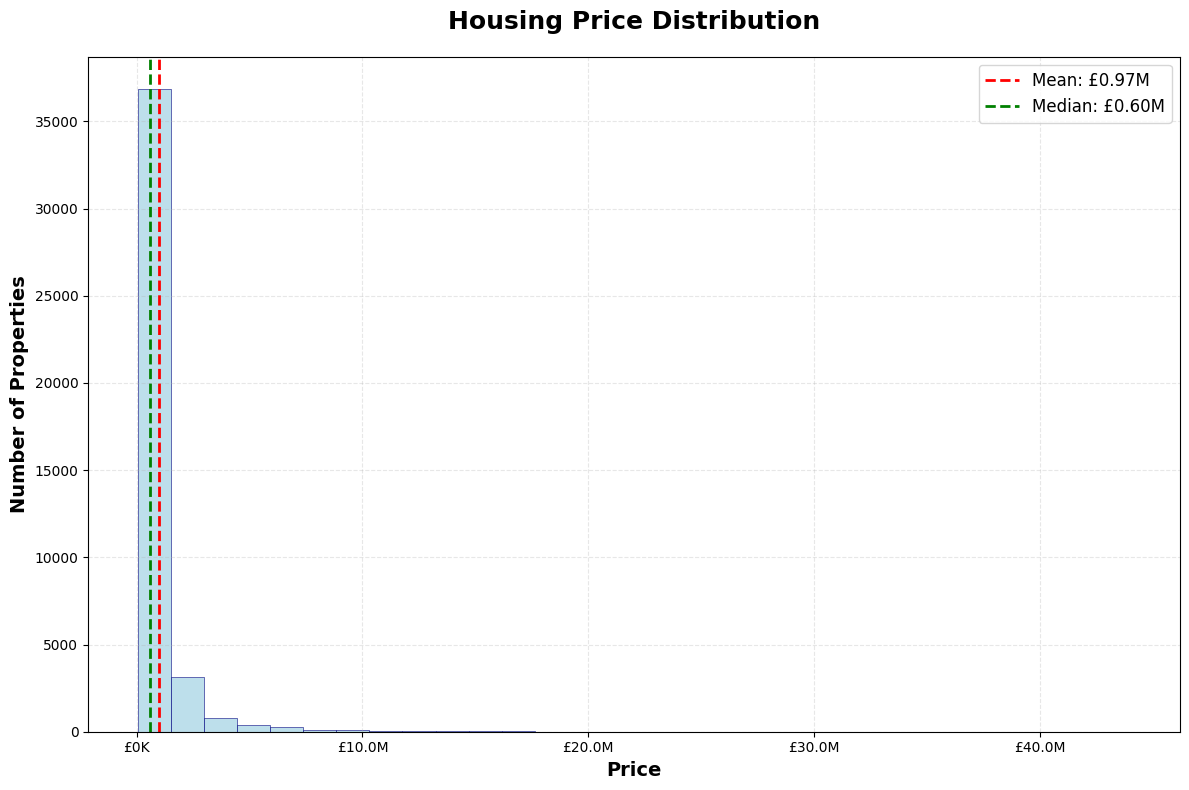

📊 PRICE DISTRIBUTION STATISTICS
Count:     41,826 properties
Mean:      £969,025
Median:    £600,000
Min:       £50,000
Max:       £44,000,000
Std Dev:   £1,502,917
Skewness:  8.37


In [12]:
# Import visualization library
import matplotlib.pyplot as plt
import numpy as np

# Create clearer price distribution histogram
plt.figure(figsize=(12, 8))

# Create histogram with better formatting
n, bins, patches = plt.hist(df['price'], bins=30, alpha=0.8, color='lightblue', 
                           edgecolor='navy', linewidth=0.5)

# Format price axis to show values in millions/thousands
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'£{x/1000000:.1f}M' if x >= 1000000 else f'£{x/1000:.0f}K'))

# Improve titles and labels
plt.title('Housing Price Distribution', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Price', fontsize=14, fontweight='bold')
plt.ylabel('Number of Properties', fontsize=14, fontweight='bold')

# Add grid for easier reading
plt.grid(True, alpha=0.3, linestyle='--')

# Add mean and median lines
mean_price = df['price'].mean()
median_price = df['price'].median()

plt.axvline(mean_price, color='red', linestyle='--', linewidth=2, 
           label=f'Mean: £{mean_price/1000000:.2f}M')
plt.axvline(median_price, color='green', linestyle='--', linewidth=2, 
           label=f'Median: £{median_price/1000000:.2f}M')

# Add legend
plt.legend(fontsize=12)

# Improve layout
plt.tight_layout()
plt.show()

# Enhanced statistics with better formatting
print("📊 PRICE DISTRIBUTION STATISTICS")
print("=" * 40)
print(f"Count:     {len(df):,} properties")
print(f"Mean:      £{df['price'].mean():,.0f}")
print(f"Median:    £{df['price'].median():,.0f}")
print(f"Min:       £{df['price'].min():,.0f}")
print(f"Max:       £{df['price'].max():,.0f}")
print(f"Std Dev:   £{df['price'].std():,.0f}")
print(f"Skewness:  {df['price'].skew():.2f}")

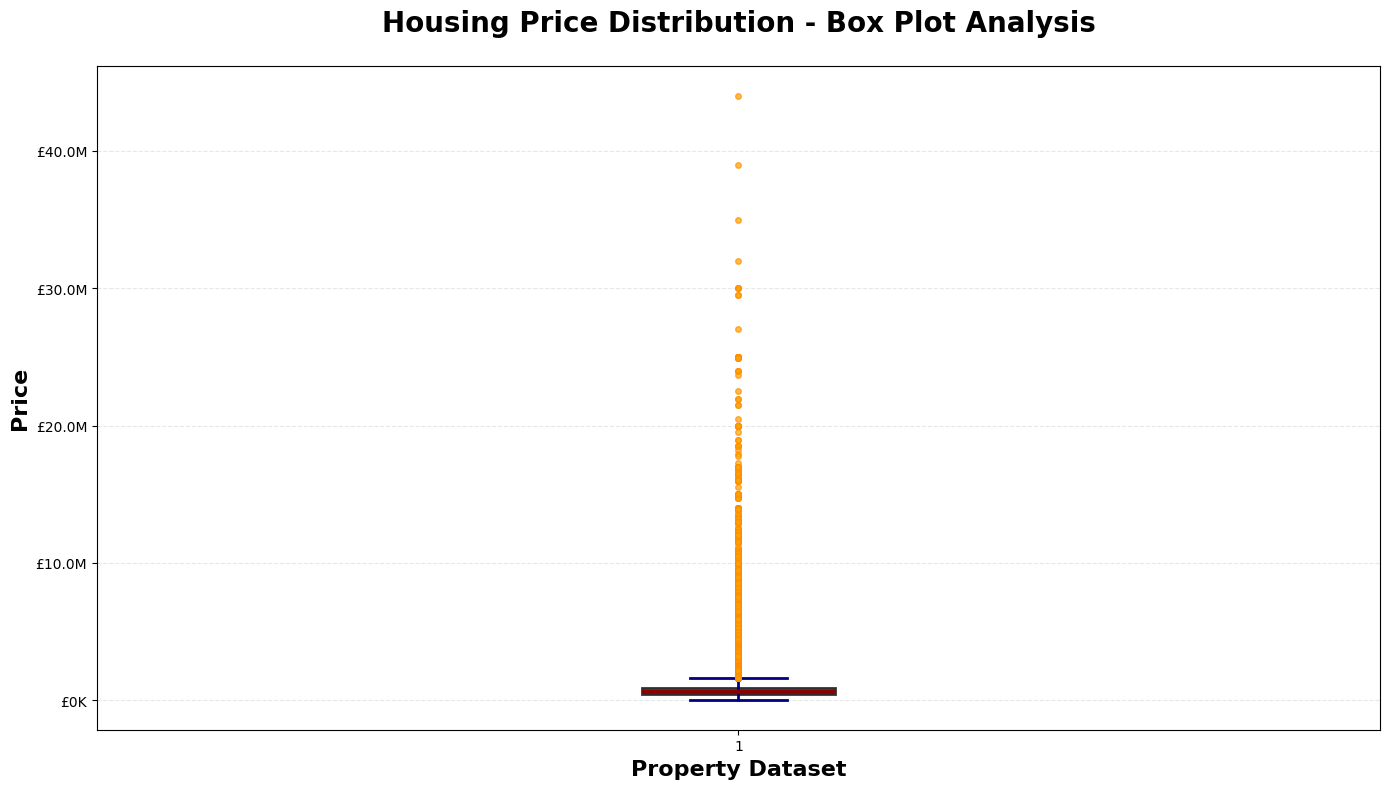

📊 COMPREHENSIVE BOX PLOT STATISTICS
📈 Central Tendency:
   Median (50th percentile): £600,000
   Q1 (25th percentile):     £425,000
   Q3 (75th percentile):     £900,000

📏 Spread & Variability:
   IQR (Q3 - Q1):           £475,000
   Lower fence (Q1 - 1.5×IQR): £-287,500
   Upper fence (Q3 + 1.5×IQR): £1,612,500

🎯 Extreme Values:
   Minimum price:            £50,000
   Maximum price:            £44,000,000
   Range:                    £43,950,000

🔍 Outlier Analysis:
   Total outliers:           4,692 (11.2%)
   High-end outliers:        4,692 (above £1.6M)
   Low-end outliers:         0 (below £-287,500)

💡 Distribution Insights:
   📊 Distribution is relatively balanced
   📈 50% of properties are priced between £0.42M - £0.90M
   🏠 Typical property price range covers £0.47M spread


In [15]:
# Create an improved box plot for price distribution
plt.figure(figsize=(14, 8))

# Create box plot with better styling
box_plot = plt.boxplot(df['price'], vert=True, patch_artist=True, 
                       boxprops=dict(facecolor='lightblue', alpha=0.8, linewidth=2),
                       medianprops=dict(color='darkred', linewidth=3),
                       whiskerprops=dict(linewidth=2, color='navy'),
                       capprops=dict(linewidth=2, color='navy'),
                       flierprops=dict(marker='o', markerfacecolor='orange', 
                                     markeredgecolor='darkorange', markersize=4, alpha=0.7))

# Format y-axis to show values in millions/thousands
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'£{x/1000000:.1f}M' if x >= 1000000 else f'£{x/1000:.0f}K'))

# Improve titles and labels
plt.title('Housing Price Distribution - Box Plot Analysis', fontsize=20, fontweight='bold', pad=25)
plt.ylabel('Price', fontsize=16, fontweight='bold')
plt.xlabel('Property Dataset', fontsize=16, fontweight='bold')

# Add horizontal grid for easier reading
plt.grid(True, alpha=0.3, linestyle='--', axis='y')

# Calculate quartile information
q1 = df['price'].quantile(0.25)
q3 = df['price'].quantile(0.75)
median = df['price'].median()
iqr = q3 - q1

# Adjust layout to accommodate annotations
plt.subplots_adjust(right=0.85)
plt.tight_layout()
plt.show()

# Enhanced statistics with better formatting
print("📊 COMPREHENSIVE BOX PLOT STATISTICS")
print("=" * 50)
print(f"📈 Central Tendency:")
print(f"   Median (50th percentile): £{median:,.0f}")
print(f"   Q1 (25th percentile):     £{q1:,.0f}")
print(f"   Q3 (75th percentile):     £{q3:,.0f}")

print(f"\n📏 Spread & Variability:")
print(f"   IQR (Q3 - Q1):           £{iqr:,.0f}")
print(f"   Lower fence (Q1 - 1.5×IQR): £{(q1 - 1.5*iqr):,.0f}")
print(f"   Upper fence (Q3 + 1.5×IQR): £{(q3 + 1.5*iqr):,.0f}")

print(f"\n🎯 Extreme Values:")
print(f"   Minimum price:            £{df['price'].min():,.0f}")
print(f"   Maximum price:            £{df['price'].max():,.0f}")
print(f"   Range:                    £{(df['price'].max() - df['price'].min()):,.0f}")

# Count outliers with detailed breakdown
outliers = df[(df['price'] < (q1 - 1.5*iqr)) | (df['price'] > (q3 + 1.5*iqr))]
high_outliers = df[df['price'] > (q3 + 1.5*iqr)]
low_outliers = df[df['price'] < (q1 - 1.5*iqr)]

print(f"\n🔍 Outlier Analysis:")
print(f"   Total outliers:           {len(outliers):,} ({len(outliers)/len(df)*100:.1f}%)")
print(f"   High-end outliers:        {len(high_outliers):,} (above £{(q3 + 1.5*iqr)/1000000:.1f}M)")
print(f"   Low-end outliers:         {len(low_outliers):,} (below £{(q1 - 1.5*iqr):,.0f})")

print(f"\n💡 Distribution Insights:")
if median > (q1 + q3) / 2:
    print("   📊 Distribution is right-skewed (higher-priced properties pull the median up)")
else:
    print("   📊 Distribution is relatively balanced")
    
print(f"   📈 50% of properties are priced between £{q1/1000000:.2f}M - £{q3/1000000:.2f}M")
print(f"   🏠 Typical property price range covers £{iqr/1000000:.2f}M spread")

In [1]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv(r'C:\Users\Jc\Desktop\Dissertation\Code\finalized_baseline_dataset_categorical.csv')

print("📊 COMPREHENSIVE SUMMARY STATISTICS")
print("=" * 80)

# Select key numerical variables for summary
numerical_vars = [
    'price',
    'bedrooms', 
    'bathrooms', 
    'size_sqft',
    'parking',
    'garden',
    'council_tax',
    'min_station_distance',
    'nearby_stations_count',
    'annual_crime_vehicle_crime',
    'annual_crime_other_theft',
    'annual_crime_shoplifting',

    'annual_crime_burglary',
    'annual_total_crimes',
    'annual_crime_theft_from_the_person',
    'annual_crime_robbery',
    'annual_crime_bicycle_theft',
    'annual_crime_public_order'
]

# Filter to only available columns
available_vars = [var for var in numerical_vars if var in df.columns]

# Calculate summary statistics
summary_stats = []

for var in available_vars:
    # Convert to numeric and handle missing values
    series = pd.to_numeric(df[var], errors='coerce')
    
    stats = {
        'Variable': var,
        'Mean': series.mean(),
        'SD': series.std(),
        'Min': series.min(),
        'Q1': series.quantile(0.25),
        'Median': series.median(),
        'Q3': series.quantile(0.75),
        'Max': series.max(),
        'Count': series.count(),
        'Missing': series.isna().sum()
    }
    summary_stats.append(stats)

# Create DataFrame for better formatting
summary_df = pd.DataFrame(summary_stats)

# Format the display
print(f"\n📋 Summary Statistics for {len(df):,} Properties")
print("=" * 120)

# Create formatted table
print(f"{'Variable':<25} {'Mean':<12} {'SD':<12} {'Min':<12} {'Q1':<12} {'Median':<12} {'Q3':<12} {'Max':<12}")
print("-" * 120)

for _, row in summary_df.iterrows():
    var_name = row['Variable']
    
    # Special formatting for different variable types
    if 'price' in var_name.lower():
        # Format price in thousands/millions
        mean_fmt = f"£{row['Mean']/1000000:.2f}M" if row['Mean'] >= 1000000 else f"£{row['Mean']/1000:.0f}K"
        sd_fmt = f"£{row['SD']/1000:.0f}K"
        min_fmt = f"£{row['Min']/1000:.0f}K"
        q1_fmt = f"£{row['Q1']/1000:.0f}K"
        med_fmt = f"£{row['Median']/1000:.0f}K"
        q3_fmt = f"£{row['Q3']/1000:.0f}K"
        max_fmt = f"£{row['Max']/1000000:.2f}M" if row['Max'] >= 1000000 else f"£{row['Max']/1000:.0f}K"
    
    elif 'crime' in var_name.lower():
        # Format crime statistics as integers
        mean_fmt = f"{row['Mean']:.1f}"
        sd_fmt = f"{row['SD']:.1f}"
        min_fmt = f"{row['Min']:.0f}"
        q1_fmt = f"{row['Q1']:.0f}"
        med_fmt = f"{row['Median']:.0f}"
        q3_fmt = f"{row['Q3']:.0f}"
        max_fmt = f"{row['Max']:.0f}"
    
    elif var_name in ['parking', 'garden']:
        # Format binary variables
        mean_fmt = f"{row['Mean']:.3f}"
        sd_fmt = f"{row['SD']:.3f}"
        min_fmt = f"{row['Min']:.0f}"
        q1_fmt = f"{row['Q1']:.0f}"
        med_fmt = f"{row['Median']:.0f}"
        q3_fmt = f"{row['Q3']:.0f}"
        max_fmt = f"{row['Max']:.0f}"
    
    elif 'distance' in var_name.lower():
        # Format distance in km/miles
        mean_fmt = f"{row['Mean']:.2f}"
        sd_fmt = f"{row['SD']:.2f}"
        min_fmt = f"{row['Min']:.2f}"
        q1_fmt = f"{row['Q1']:.2f}"
        med_fmt = f"{row['Median']:.2f}"
        q3_fmt = f"{row['Q3']:.2f}"
        max_fmt = f"{row['Max']:.2f}"
    
    else:
        # Default formatting for other variables
        mean_fmt = f"{row['Mean']:.2f}"
        sd_fmt = f"{row['SD']:.2f}"
        min_fmt = f"{row['Min']:.1f}"
        q1_fmt = f"{row['Q1']:.1f}"
        med_fmt = f"{row['Median']:.1f}"
        q3_fmt = f"{row['Q3']:.1f}"
        max_fmt = f"{row['Max']:.1f}"
    
    print(f"{var_name:<25} {mean_fmt:<12} {sd_fmt:<12} {min_fmt:<12} {q1_fmt:<12} {med_fmt:<12} {q3_fmt:<12} {max_fmt:<12}")

# Additional summary information
print("\n" + "=" * 120)
print("📊 DATASET OVERVIEW")
print("=" * 120)

print(f"📋 Total Properties: {len(df):,}")
print(f"📋 Total Features: {len(df.columns)}")
print(f"📋 Numerical Features: {len(available_vars)}")

# Categorical variables summary
categorical_vars = ['property_type', 'tenure_type']
print(f"\n🏷️ CATEGORICAL VARIABLES:")
for var in categorical_vars:
    if var in df.columns:
        unique_count = df[var].nunique()
        most_common = df[var].mode().iloc[0] if len(df[var].mode()) > 0 else 'N/A'
        missing = df[var].isna().sum()
        print(f"   {var:<20}: {unique_count} categories, Most common: {most_common}, Missing: {missing}")

# Missing data summary
print(f"\n❓ MISSING DATA SUMMARY:")
missing_summary = df[available_vars].isnull().sum().sort_values(ascending=False)
missing_summary = missing_summary[missing_summary > 0]

if len(missing_summary) > 0:
    for var, missing_count in missing_summary.items():
        missing_pct = (missing_count / len(df)) * 100
        print(f"   {var:<25}: {missing_count:,} ({missing_pct:.1f}%)")
else:
    print("   ✅ No missing values in numerical variables!")

# Correlation insights for key variables
print(f"\n🔗 KEY CORRELATIONS WITH PRICE:")
if 'price' in df.columns:
    key_vars = ['bedrooms', 'bathrooms', 'size_sqft', 'council_tax', 'min_station_distance']
    available_key_vars = [var for var in key_vars if var in df.columns]
    
    for var in available_key_vars:
        corr = df['price'].corr(pd.to_numeric(df[var], errors='coerce'))
        corr_strength = "Strong" if abs(corr) > 0.5 else "Moderate" if abs(corr) > 0.3 else "Weak"
        direction = "Positive" if corr > 0 else "Negative"
        print(f"   {var:<25}: {corr:.3f} ({corr_strength} {direction})")

print(f"\n✅ Summary statistics generated for {len(available_vars)} numerical variables")
print(f"📊 Ready for baseline model comparison and BERT model evaluation!")


📊 COMPREHENSIVE SUMMARY STATISTICS

📋 Summary Statistics for 41,826 Properties
Variable                  Mean         SD           Min          Q1           Median       Q3           Max         
------------------------------------------------------------------------------------------------------------------------
price                     £969K        £1503K       £50K         £425K        £600K        £900K        £44.00M     
bedrooms                  2.60         1.46         0.0          2.0          2.0          3.0          99.0        
bathrooms                 33.06        2965.55      0.0          2.0          2.0          3.0          371371.0    
size_sqft                 760.49       2703.52      0.0          0.0          539.0        1013.0       336989.0    
parking                   0.417        0.493        0            0            0            1            1           
garden                    0.500        0.500        0            0            0            1      

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load the dataset
df = pd.read_csv(r'C:\Users\Jc\Desktop\Dissertation\Code\finalized_baseline_dataset_categorical.csv')

print("📊 CREATING FREQUENCY HISTOGRAMS FOR KEY VARIABLES")
print("=" * 60)

# Create a 2x2 subplot layout for all 4 variables
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Frequency Histograms for Key Property Variables', fontsize=18, fontweight='bold', y=0.98)

# Define variables and their formatting
variables = [
    ('price', 'Price Distribution', '£', lambda x: f'£{x/1000000:.1f}M' if x >= 1000000 else f'£{x/1000:.0f}K'),
    ('bedrooms', 'Bedrooms Distribution', 'Bedrooms', lambda x: f'{int(x)}'),
    ('bathrooms', 'Bathrooms Distribution', 'Bathrooms', lambda x: f'{x:.1f}'),
    ('size_sqft', 'Size Distribution', 'Square Feet', lambda x: f'{x/1000:.0f}K' if x >= 1000 else f'{int(x)}')
]

# Plot each histogram
for i, (var, title, xlabel, formatter) in enumerate(variables):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    if var in df.columns:
        # Convert to numeric and remove missing values
        data = pd.to_numeric(df[var], errors='coerce').dropna()
        
        # Determine number of bins based on data type
        if var == 'bedrooms':
            bins = range(int(data.min()), int(data.max()) + 2)  # Integer bins for bedrooms
        elif var == 'bathrooms':
            bins = np.arange(data.min(), data.max() + 0.5, 0.5)  # 0.5 increments for bathrooms
        else:
            bins = 30  # Default bins for continuous variables
        
        # Create histogram
        n, bin_edges, patches = ax.hist(data, bins=bins, alpha=0.8, color='lightblue', 
                                       edgecolor='navy', linewidth=0.8)
        
        # Customize each subplot
        ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
        ax.set_xlabel(xlabel, fontsize=12, fontweight='bold')
        ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, linestyle='--')
        
        # Format x-axis based on variable type
        if var in ['price', 'size_sqft']:
            ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: formatter(x)))
        
        # Add statistics text box
        mean_val = data.mean()
        median_val = data.median()
        std_val = data.std()
        
        stats_text = f'Count: {len(data):,}\n'
        stats_text += f'Mean: {formatter(mean_val)}\n'
        stats_text += f'Median: {formatter(median_val)}\n'
        stats_text += f'Std: {std_val:.2f}'
        
        # Position text box in upper right
        ax.text(0.65, 0.95, stats_text, transform=ax.transAxes, 
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
               fontsize=10)
        
        # Add mean and median lines for continuous variables
        if var in ['price', 'size_sqft']:
            ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Mean')
            ax.axvline(median_val, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Median')
            ax.legend(fontsize=10)
        
        print(f"✅ {title} histogram created")
        print(f"   📊 Count: {len(data):,}")
        print(f"   📈 Range: {formatter(data.min())} - {formatter(data.max())}")
        print(f"   📊 Mean: {formatter(mean_val)}")
        print(f"   📊 Median: {formatter(median_val)}")
        print()
        
    else:
        ax.text(0.5, 0.5, f'{var} not found\nin dataset', 
               ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_title(f'{var} - Not Available', fontsize=14)

# Adjust layout and show
plt.tight_layout()
plt.subplots_adjust(top=0.94)  # Make room for main title
plt.show()

# Create individual detailed histograms
print("\n" + "="*80)
print("📈 DETAILED INDIVIDUAL HISTOGRAMS")
print("="*80)

# Individual histogram for Price with more detail
plt.figure(figsize=(12, 8))
if 'price' in df.columns:
    price_data = pd.to_numeric(df['price'], errors='coerce').dropna()
    
    # Create histogram with more bins for detail
    n, bins, patches = plt.hist(price_data, bins=50, alpha=0.8, color='lightblue', 
                               edgecolor='navy', linewidth=0.5)
    
    # Format axis
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(
        lambda x, p: f'£{x/1000000:.1f}M' if x >= 1000000 else f'£{x/1000:.0f}K'))
    
    plt.title('Property Price Distribution (Detailed)', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Price', fontsize=14, fontweight='bold')
    plt.ylabel('Frequency', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, linestyle='--')
    
    # Add quartile lines
    q1 = price_data.quantile(0.25)
    q2 = price_data.quantile(0.50)  # median
    q3 = price_data.quantile(0.75)
    mean_price = price_data.mean()
    
    plt.axvline(q1, color='orange', linestyle=':', linewidth=2, label=f'Q1: £{q1/1000:.0f}K')
    plt.axvline(q2, color='green', linestyle='--', linewidth=2, label=f'Median: £{q2/1000:.0f}K')
    plt.axvline(q3, color='purple', linestyle=':', linewidth=2, label=f'Q3: £{q3/1000:.0f}K')
    plt.axvline(mean_price, color='red', linestyle='-', linewidth=2, label=f'Mean: £{mean_price/1000:.0f}K')
    
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

# Summary statistics table for the 4 key variables
print("\n📋 FREQUENCY SUMMARY FOR KEY VARIABLES")
print("="*80)

key_vars = ['price', 'bedrooms', 'bathrooms', 'size_sqft']
summary_data = []

for var in key_vars:
    if var in df.columns:
        data = pd.to_numeric(df[var], errors='coerce').dropna()
        
        # Count frequencies for discrete variables
        if var in ['bedrooms', 'bathrooms']:
            freq_counts = data.value_counts().sort_index()
            print(f"\n🏠 {var.upper()} FREQUENCY DISTRIBUTION:")
            print("-" * 40)
            for value, count in freq_counts.items():
                percentage = (count / len(data)) * 100
                print(f"   {value:>4}: {count:>6,} ({percentage:>5.1f}%)")
        
        summary_data.append({
            'Variable': var,
            'Count': len(data),
            'Mean': data.mean(),
            'Median': data.median(),
            'Std': data.std(),
            'Min': data.min(),
            'Max': data.max()
        })

# Create summary table
summary_df = pd.DataFrame(summary_data)
print(f"\n📊 SUMMARY STATISTICS TABLE:")
print("-" * 80)
print(f"{'Variable':<12} {'Count':<8} {'Mean':<12} {'Median':<12} {'Std':<12} {'Min':<10} {'Max':<10}")
print("-" * 80)

for _, row in summary_df.iterrows():
    var = row['Variable']
    if var == 'price':
        print(f"{var:<12} {row['Count']:<8,.0f} £{row['Mean']:<11,.0f} £{row['Median']:<11,.0f} £{row['Std']:<11,.0f} £{row['Min']:<9,.0f} £{row['Max']:<9,.0f}")
    elif var == 'size_sqft':
        print(f"{var:<12} {row['Count']:<8,.0f} {row['Mean']:<12,.0f} {row['Median']:<12,.0f} {row['Std']:<12,.0f} {row['Min']:<10,.0f} {row['Max']:<10,.0f}")
    else:
        print(f"{var:<12} {row['Count']:<8,.0f} {row['Mean']:<12.2f} {row['Median']:<12.1f} {row['Std']:<12.2f} {row['Min']:<10.1f} {row['Max']:<10.1f}")

print(f"\n✅ All frequency histograms generated successfully!")
print(f"📊 {len(key_vars)} key variables analyzed with detailed frequency distributions")

📊 CREATING FREQUENCY HISTOGRAMS FOR KEY VARIABLES
✅ Price Distribution histogram created
   📊 Count: 41,826
   📈 Range: £50K - £44.0M
   📊 Mean: £969K
   📊 Median: £600K

✅ Bedrooms Distribution histogram created
   📊 Count: 41,826
   📈 Range: 0 - 99
   📊 Mean: 2
   📊 Median: 2

✅ Bathrooms Distribution histogram created
   📊 Count: 41,826
   📈 Range: 0.0 - 371371.0
   📊 Mean: 33.1
   📊 Median: 2.0

✅ Size Distribution histogram created
   📊 Count: 41,826
   📈 Range: 0 - 337K
   📊 Mean: 760
   📊 Median: 539



: 

In [1]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv(r'C:\Users\Jc\Desktop\Dissertation\Code\finalized_baseline_dataset_categorical.csv')

print("🚨 DATA QUALITY ANALYSIS - IDENTIFYING OUTLIERS")
print("=" * 80)

# Check for suspicious outliers in each variable
suspicious_variables = ['price', 'bedrooms', 'bathrooms', 'size_sqft']

for var in suspicious_variables:
    if var in df.columns:
        data = pd.to_numeric(df[var], errors='coerce')
        
        print(f"\n🔍 {var.upper()} OUTLIER ANALYSIS:")
        print("-" * 50)
        
        # Basic statistics
        print(f"   Count: {data.count():,}")
        print(f"   Mean: {data.mean():.2f}")
        print(f"   Median: {data.median():.2f}")
        print(f"   Min: {data.min():.2f}")
        print(f"   Max: {data.max():.2f}")
        print(f"   Std: {data.std():.2f}")
        
        # Identify extreme outliers using IQR method
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 3 * IQR  # 3x IQR for extreme outliers
        upper_bound = Q3 + 3 * IQR
        
        extreme_low = data[data < lower_bound]
        extreme_high = data[data > upper_bound]
        
        print(f"   🎯 Normal Range (Q1-Q3): {Q1:.2f} - {Q3:.2f}")
        print(f"   ⚠️ Extreme Outlier Bounds: < {lower_bound:.2f} or > {upper_bound:.2f}")
        print(f"   🔺 Extreme High Outliers: {len(extreme_high)} properties")
        print(f"   🔻 Extreme Low Outliers: {len(extreme_low)} properties")
        
        # Show specific problematic cases
        if var == 'bathrooms':
            weird_bathrooms = data[data > 20]  # More than 20 bathrooms is suspicious
            print(f"   🚨 Properties with >20 bathrooms: {len(weird_bathrooms)}")
            if len(weird_bathrooms) > 0:
                print(f"   📊 Max bathrooms: {weird_bathrooms.max():.0f}")
                print(f"   📊 Properties with >50 bathrooms: {len(data[data > 50])}")
        
        elif var == 'bedrooms':
            weird_bedrooms = data[data > 15]  # More than 15 bedrooms is suspicious
            print(f"   🚨 Properties with >15 bedrooms: {len(weird_bedrooms)}")
            if len(weird_bedrooms) > 0:
                print(f"   📊 Max bedrooms: {weird_bedrooms.max():.0f}")
        
        elif var == 'size_sqft':
            zero_size = data[data == 0]
            huge_size = data[data > 50000]  # More than 50,000 sqft is suspicious for typical housing
            print(f"   🚨 Properties with 0 sqft: {len(zero_size)}")
            print(f"   🚨 Properties with >50k sqft: {len(huge_size)}")
            if len(huge_size) > 0:
                print(f"   📊 Max size: {huge_size.max():,.0f} sqft")
        
        elif var == 'price':
            cheap_houses = data[data < 100000]  # Less than £100k is suspicious in most UK markets
            expensive_houses = data[data > 10000000]  # More than £10M is very high-end
            print(f"   🚨 Properties <£100k: {len(cheap_houses)}")
            print(f"   🚨 Properties >£10M: {len(expensive_houses)}")

# SPECIFIC OUTLIER INVESTIGATION
print(f"\n" + "="*80)
print("🔍 DETAILED OUTLIER INVESTIGATION")
print("="*80)

# Find rows with the most extreme outliers
print(f"\n🚨 MOST SUSPICIOUS PROPERTIES:")

# Extreme bathrooms
if 'bathrooms' in df.columns:
    max_bathrooms_idx = df['bathrooms'].idxmax()
    max_bathrooms_value = df.loc[max_bathrooms_idx, 'bathrooms']
    print(f"\n🛁 MAXIMUM BATHROOMS PROPERTY:")
    print(f"   Index: {max_bathrooms_idx}")
    print(f"   Bathrooms: {max_bathrooms_value}")
    if 'bedrooms' in df.columns:
        print(f"   Bedrooms: {df.loc[max_bathrooms_idx, 'bedrooms']}")
    if 'price' in df.columns:
        print(f"   Price: £{df.loc[max_bathrooms_idx, 'price']:,.0f}")
    if 'size_sqft' in df.columns:
        print(f"   Size: {df.loc[max_bathrooms_idx, 'size_sqft']:,.0f} sqft")

# Extreme bedrooms
if 'bedrooms' in df.columns:
    max_bedrooms_idx = df['bedrooms'].idxmax()
    max_bedrooms_value = df.loc[max_bedrooms_idx, 'bedrooms']
    print(f"\n🛏️ MAXIMUM BEDROOMS PROPERTY:")
    print(f"   Index: {max_bedrooms_idx}")
    print(f"   Bedrooms: {max_bedrooms_value}")
    if 'bathrooms' in df.columns:
        print(f"   Bathrooms: {df.loc[max_bedrooms_idx, 'bathrooms']}")
    if 'price' in df.columns:
        print(f"   Price: £{df.loc[max_bedrooms_idx, 'price']:,.0f}")

# Extreme size
if 'size_sqft' in df.columns:
    max_size_idx = df['size_sqft'].idxmax()
    max_size_value = df.loc[max_size_idx, 'size_sqft']
    print(f"\n🏠 MAXIMUM SIZE PROPERTY:")
    print(f"   Index: {max_size_idx}")
    print(f"   Size: {max_size_value:,.0f} sqft")
    if 'bedrooms' in df.columns:
        print(f"   Bedrooms: {df.loc[max_size_idx, 'bedrooms']}")
    if 'bathrooms' in df.columns:
        print(f"   Bathrooms: {df.loc[max_size_idx, 'bathrooms']}")
    if 'price' in df.columns:
        print(f"   Price: £{df.loc[max_size_idx, 'price']:,.0f}")

# DATA CLEANING RECOMMENDATIONS
print(f"\n" + "="*80)
print("💡 DATA CLEANING RECOMMENDATIONS")
print("="*80)

print(f"\n🔧 SUGGESTED OUTLIER REMOVAL THRESHOLDS:")
print(f"   🛁 Bathrooms: Cap at 10-15 bathrooms (current max: {df['bathrooms'].max():.0f})")
print(f"   🛏️ Bedrooms: Cap at 15-20 bedrooms (current max: {df['bedrooms'].max():.0f})")
print(f"   🏠 Size: Remove 0 sqft and cap at 20,000-50,000 sqft (current max: {df['size_sqft'].max():,.0f})")
print(f"   💰 Price: Consider £50k-£20M range (current max: £{df['price'].max():,.0f})")

print(f"\n🎯 POTENTIAL DATA ISSUES:")
print(f"   ⚠️ 371,371 bathrooms = Likely data entry error")
print(f"   ⚠️ 99 bedrooms = Possibly apartment building counted incorrectly")
print(f"   ⚠️ 336,989 sqft = Could be commercial property or data error")
print(f"   ⚠️ £44M price = Legitimate luxury property but affects model training")

print(f"\n✅ NEXT STEPS:")
print(f"   1. Investigate extreme outliers manually")
print(f"   2. Apply reasonable caps/filters based on UK housing market")
print(f"   3. Consider log transformation for price and size")
print(f"   4. Check if outliers are data entry errors vs legitimate properties")

🚨 DATA QUALITY ANALYSIS - IDENTIFYING OUTLIERS

🔍 PRICE OUTLIER ANALYSIS:
--------------------------------------------------
   Count: 41,826
   Mean: 969025.09
   Median: 600000.00
   Min: 50000.00
   Max: 44000000.00
   Std: 1502917.23
   🎯 Normal Range (Q1-Q3): 425000.00 - 900000.00
   ⚠️ Extreme Outlier Bounds: < -1000000.00 or > 2325000.00
   🔺 Extreme High Outliers: 2695 properties
   🔻 Extreme Low Outliers: 0 properties
   🚨 Properties <£100k: 89
   🚨 Properties >£10M: 196

🔍 BEDROOMS OUTLIER ANALYSIS:
--------------------------------------------------
   Count: 41,826
   Mean: 2.60
   Median: 2.00
   Min: 0.00
   Max: 99.00
   Std: 1.46
   🎯 Normal Range (Q1-Q3): 2.00 - 3.00
   ⚠️ Extreme Outlier Bounds: < -1.00 or > 6.00
   🔺 Extreme High Outliers: 396 properties
   🔻 Extreme Low Outliers: 0 properties
   🚨 Properties with >15 bedrooms: 9
   📊 Max bedrooms: 99

🔍 BATHROOMS OUTLIER ANALYSIS:
--------------------------------------------------
   Count: 41,826
   Mean: 33.06
   M